In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import shap
shap.initjs()

c:\Users\Violet\Documents\GitHub\PerovskiteML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import custom scripts
from scripts import *

Data utils loaded


In [3]:
# Threshold (%) of data for a feature to be included
THRESHOLD = 0.75
# Depth Threshold (%) of data included from layer data.
# --- picks the maximum depth that includes the threshold % of devices
DEPTH_THRESHOLD = 0.75

TARGET_COL = "JV_default_PCE"

In [4]:
data, selector = preprocess_data(
    THRESHOLD,
    DEPTH_THRESHOLD,
    exclude_sections=[
      "Reference information",
      "Cell definition",
      "Outdoor testing",
      # "Additional layers",
      "JV data"
      ],
    exclude_cols=[
      "Outdoor_time_start",
      "Outdoor_time_end"
      ],
    verbose=False
)

# Process target data
mask = DATASET.data[TARGET_COL].notna()
X = data[mask]
# X.drop(columns=[TARGET_COL, "JV_reverse_scan_PCE"], inplace=True)
y = DATASET.data[mask][TARGET_COL]

print(X.shape)
print(y.shape)

c:\Users\Violet\Documents\GitHub\PerovskiteML\src\notebooks
Loading Perovskite Data...
../../data/Perovskite_database.csv
Loading Reference Data...
../../data/pdp_units_data.xlsx
Data Initialized.
Preprocessing Data...
Threshold: 0.75, Depth: 0.75
Data Preprocessed.


c:\Users\Violet\Documents\GitHub\PerovskiteML\src\data_utils\__init__.py:96: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(col, errors='ignore')


(42258, 61)
(42258,)


In [5]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

numerical_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_include=[bool, object])

preprocessor = ColumnTransformer([
    ('numerical', 'passthrough', numerical_selector),
    ('categorical', encoder, categorical_selector),
])

# # scaler = StandardScaler().set_output(transform="pandas")
# # preprocessor = make_pipeline(column_preprocessor, scaler)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbregressor', xgb_model)
])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD714A2150>),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD70D13440>)])),
                (...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}, RMSE: {mse**0.5:.2f}")

MSE: 11.27, RMSE: 3.36


In [7]:
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
display_scores(-scores)

Scores: [3.9337445  3.93247827 3.82358114 4.07217442 4.2372762 ]
Mean: 4.000
Std: 0.143


In [8]:
all_columns = list(X.select_dtypes(np.number).columns) + list(X.select_dtypes([bool, object]).columns)
X_transformed = pd.DataFrame(model.named_steps['preprocessor'].transform(X))
X_transformed.columns = all_columns

X_display = X[all_columns]

explainer = shap.TreeExplainer(model.named_steps['xgbregressor'])
shap_values = explainer.shap_values(X_transformed)

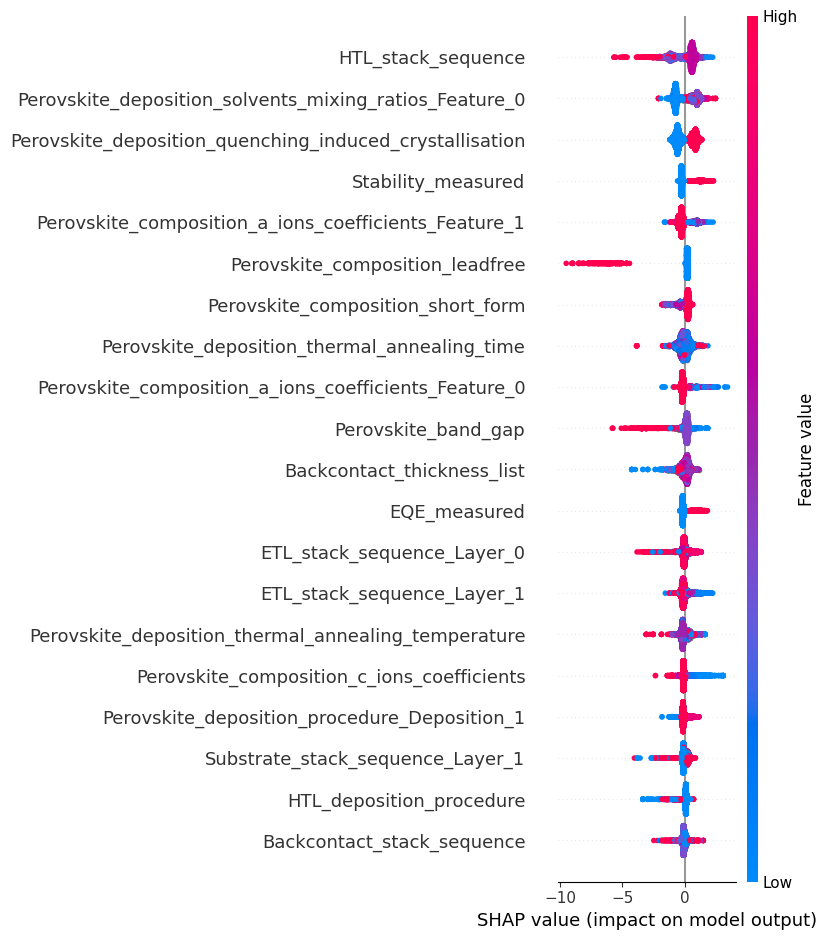

In [9]:
shap.summary_plot(shap_values[:10000, :], X_transformed.iloc[:10000, :])

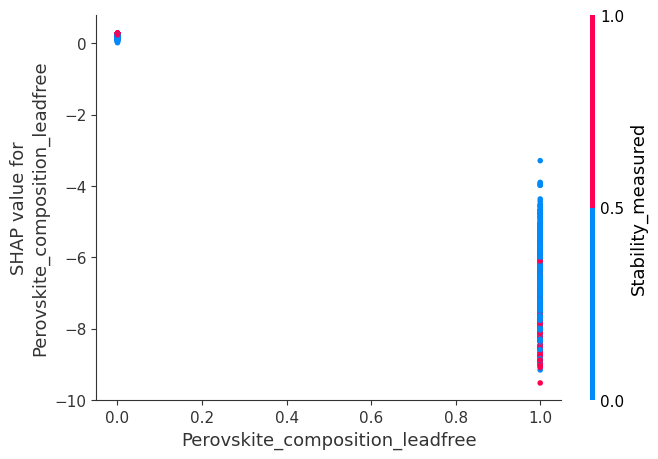

In [10]:
shap.dependence_plot('Perovskite_composition_leadfree', shap_values, X_transformed, display_features=X_display)

In [11]:
shap.force_plot(explainer.expected_value, shap_values[40000, :], X_display.iloc[40000, :])

In [12]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :])

In [15]:
X_display['HTL_stack_sequence'].value_counts()

HTL_stack_sequence
Spiro-MeOTAD    20799
PEDOT:PSS        6986
PTAA             2183
NiO-c            1886
P3HT              918
                ...  
BTDTP               1
BMIMBF4             1
DBT(QT-TPA)2        1
T(EDOT-TPA)2        1
DM1                 1
Name: count, Length: 1549, dtype: int64